In [5]:
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import psycopg2
import cv2
import datetime as dt

from build.api_app.database import get_available_images, upload_image, get_image_slice

TARGET_WIDTH = 150

# Data preprocessing

In [182]:
df = pd.read_csv("img.csv")
df.dropna(inplace=True)
depth_col = df['depth'].values
cols= [col for col in df.columns.to_list() if col.startswith("col")]
df = df[cols]
df

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col191,col192,col193,col194,col195,col196,col197,col198,col199,col200
0,224.0,224.0,224.0,224.0,224.0,224.0,224.0,224.0,224.0,224.0,...,224.0,225.0,226.0,225.0,224.0,223.0,221.0,220.0,217.0,217.0
1,224.0,224.0,224.0,224.0,224.0,224.0,224.0,224.0,224.0,224.0,...,224.0,225.0,226.0,225.0,224.0,223.0,222.0,221.0,219.0,219.0
2,224.0,224.0,224.0,224.0,224.0,224.0,224.0,224.0,224.0,224.0,...,224.0,225.0,226.0,226.0,225.0,224.0,224.0,223.0,223.0,223.0
3,224.0,224.0,224.0,224.0,224.0,224.0,224.0,224.0,224.0,224.0,...,224.0,225.0,226.0,226.0,225.0,225.0,225.0,225.0,225.0,225.0
4,224.0,224.0,224.0,224.0,224.0,224.0,224.0,224.0,224.0,224.0,...,225.0,224.0,223.0,223.0,224.0,224.0,225.0,225.0,225.0,225.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5455,203.0,202.0,199.0,195.0,193.0,190.0,188.0,186.0,181.0,178.0,...,182.0,185.0,186.0,186.0,187.0,185.0,182.0,176.0,171.0,169.0
5456,209.0,206.0,199.0,194.0,195.0,195.0,189.0,187.0,198.0,213.0,...,188.0,195.0,200.0,203.0,201.0,185.0,166.0,164.0,169.0,170.0
5457,184.0,188.0,198.0,205.0,205.0,203.0,197.0,193.0,201.0,212.0,...,185.0,186.0,189.0,195.0,197.0,184.0,168.0,167.0,173.0,174.0
5458,147.0,161.0,195.0,218.0,218.0,212.0,207.0,201.0,197.0,194.0,...,177.0,169.0,167.0,175.0,183.0,182.0,178.0,177.0,179.0,180.0


In [145]:
image = df.to_numpy(dtype=np.int16)

In [129]:
print(f"Image has (Width x Height): {image.shape[1]} x {image.shape[0]}")

# plt.figure(figsize=(3,20))
# plt.imshow(image, cmap='viridis')
# plt.imsave('raw_image.png', image, cmap='viridis')
# plt.colorbar()
# plt.grid(False)
# plt.show()

Image has (Width x Height): 200 x 5460


## Resize

In [133]:
resized_image = cv2.resize(
    src=image,
    dsize=(TARGET_WIDTH, image.shape[0]),
    interpolation=cv2.INTER_LINEAR
).astype(np.int16)

In [135]:
print(f"Image has (Width x Height): {resized_image.shape[1]} x {resized_image.shape[0]}")

# plt.figure(figsize=(3,20))
# plt.imshow(resized_image, cmap='viridis')
# plt.imsave('resized_image.png', resized_image, cmap='viridis')
# plt.colorbar()
# plt.grid(False)
# plt.show()

Image has (Width x Height): 150 x 5460


In [183]:
resized_df = pd.DataFrame(resized_image)
resized_df['depth'] = depth_col
resized_df

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,depth
0,224,224,224,224,224,224,224,224,224,224,...,224,224,225,226,224,223,221,218,217,9000.1
1,224,224,224,224,224,224,224,224,224,224,...,224,224,225,226,224,223,222,220,219,9000.2
2,224,224,224,224,224,224,224,224,224,224,...,224,224,225,226,226,224,224,223,223,9000.3
3,224,224,224,224,224,224,224,224,224,224,...,224,224,225,226,226,225,225,225,225,9000.4
4,224,224,224,224,224,224,224,224,224,224,...,225,225,224,223,224,224,225,225,225,9000.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5455,203,200,196,192,189,186,180,180,190,189,...,180,182,184,186,186,185,181,174,169,9545.6
5456,208,202,195,195,192,187,200,212,204,197,...,187,187,194,201,202,188,166,166,170,9545.7
5457,185,193,204,205,200,194,203,212,204,201,...,189,186,186,190,196,186,168,170,174,9545.8
5458,149,178,214,217,210,202,196,195,199,202,...,191,180,170,168,179,182,178,178,180,9545.9


# Result func

In [2]:
def image_preprocessing(csv_path):
    df = pd.read_csv(csv_path)
    df.dropna(inplace=True)
    depth_col = df['depth'].values
    cols= [col for col in df.columns.to_list() if col.startswith("col")]
    df = df[cols]

    image = df.to_numpy(dtype=np.int16)

    resized_image = cv2.resize(
        src=image,
        dsize=(TARGET_WIDTH, image.shape[0]),
        interpolation=cv2.INTER_LINEAR
    ).astype(np.int16)

    resized_df = pd.DataFrame(resized_image)
    resized_df['depth'] = depth_col
    return resized_df

resized_df = image_preprocessing("img.csv")
resized_df.shape

(5460, 151)

# Test

In [6]:
image_slice = get_image_slice(
    image_name="example_image_5460_150",
    min_depth=9000.2,
    max_depth=9030.5
)
# print(np.array(image_slice['image_slice']).shape)

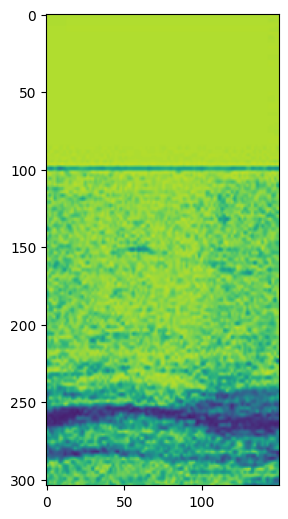

In [11]:
plt.figure(figsize=(3,20))
plt.imshow(image_slice)
plt.imsave(
    f"/Users/aweeu/Desktop/interview_test/build/api_app/user_images/{dt.datetime.now().strftime('%Y%m%d%H%M%S%f')}.png",
    arr=image_slice
)
plt.show()

In [3]:
upload_image("build/api_app/img.csv")

"Success. Image has been uploaded to db with name 'example_image_5460_150'"

In [8]:
get_available_images()

{'list_available_images': []}